In [393]:
'''
imports
'''

#standard utilities
import pandas as pd
import numpy as np
import cv2
import pickle
import random as rand

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.display import display
import seaborn as sns


#ML libraries
import sklearn
import torch
import os
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D

#set seeds for reproducability of random picks
tf.random.set_seed(1234)
rand.seed(1234, version=1)
np.random.seed(1234)

#generates random integer from range that respects seed for determinism unlike numpy and random
def tf_randint(lower, upper):
    return tf.random.uniform(shape=(), minval=1, maxval=10, dtype=tf.int32).numpy()


ä missing
ö enhance
ü done

Q1: Exploratory Data Analysis (4 Pts) 
Download and explore the data. Explore label distribution and qualitatively describe the data by
plotting healthy and pneumonia samples. Do you see visual differences between healthy and
disease samples? Do you find sources of bias that could influence model performance? How do
you preprocess the data for your further analysis?

Download and explore the data. Explore label distribution ü
There are more sick than healthy samples in the train and test sets. There are more more bacterial pneumonia samples than viral ones.

In [442]:
def count_samples(dir_path, filter_phrase=""):
    count = 0
    # Iterate directory
    for PATH in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, PATH)):
            if filter_phrase in os.path.basename(PATH):
                count += 1
    #account for duplicate Identifier files
    return int(count/2)



for subset in ["train", "val","test"]:
    print(f"Number of healthy {subset} samples: {count_samples('chest_xray/' + subset + '/NORMAL', '')}")
    print(f"Number of bacterial pneumonia {subset} samples: {count_samples('chest_xray/' + subset + '/PNEUMONIA', 'bacteria')}")
    print(f"Number of viral pneumonia {subset} samples: {count_samples('chest_xray/' + subset + '/PNEUMONIA', 'virus')}\n")

Number of healthy train samples: 1342
Number of bacterial pneumonia train samples: 2530
Number of viral pneumonia train samples: 1345

Number of healthy val samples: 9
Number of bacterial pneumonia val samples: 8
Number of viral pneumonia val samples: 0

Number of healthy test samples: 234
Number of bacterial pneumonia test samples: 242
Number of viral pneumonia test samples: 148



and qualitatively describe the data by plotting healthy and pneumonia samples. ö

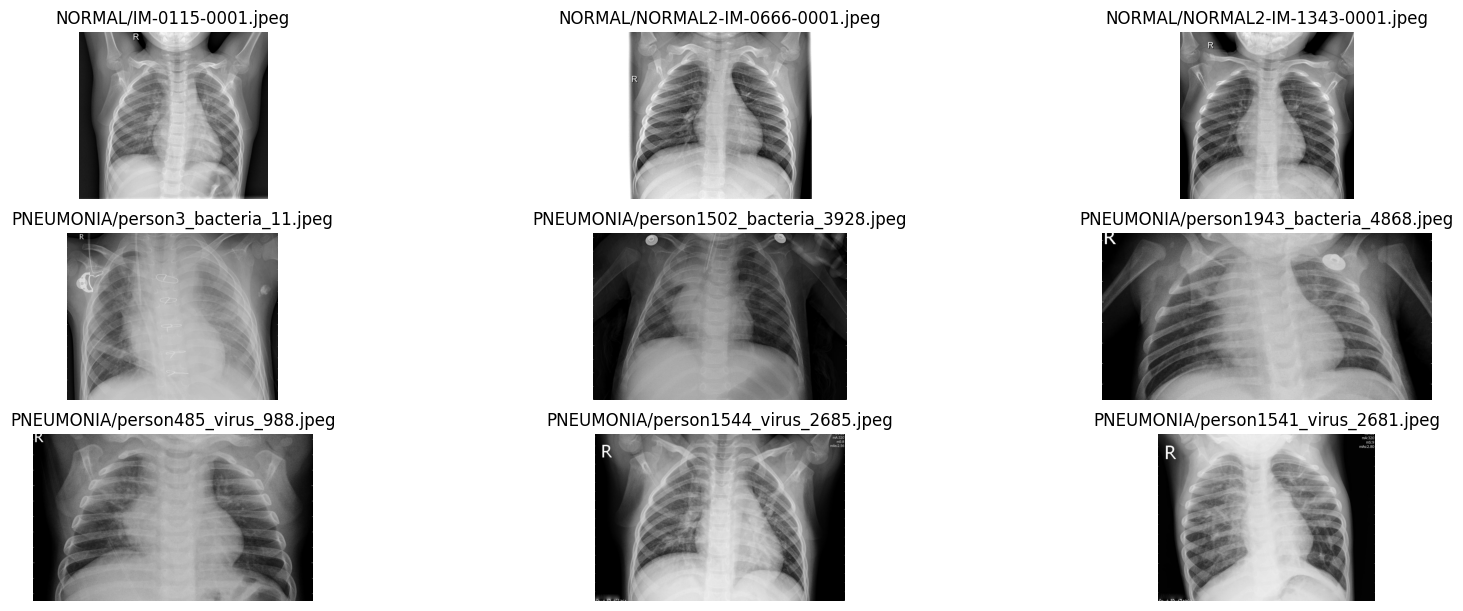

In [162]:
def plot_image_rows(file_names, columns=3):
    #plot images corresponding to list of file names in a horizontal row
    plt.figure(figsize=(20,10))
    
    for i, name in enumerate(file_names):
        #create subplots to match grid
        plt.subplot(len(file_names) // columns + 1, columns, i + 1)
        plt.imshow(plt.imread(name), cmap='gray')
        plt.axis('off')
        #get title
        title = str.split(name, '/')
        plt.title(title[2] + "/" + title[3])


BASEPATH_0 = "chest_xray/train/NORMAL/"
BASEPATH_1 = "chest_xray/train/PNEUMONIA/"
file_names = [
    BASEPATH_0 + "IM-0115-0001.jpeg",
    BASEPATH_0 + "NORMAL2-IM-0666-0001.jpeg",
    BASEPATH_0 + "NORMAL2-IM-1343-0001.jpeg",

    BASEPATH_1 + "person3_bacteria_11.jpeg",
    BASEPATH_1 + "person1502_bacteria_3928.jpeg",
    BASEPATH_1 + "person1943_bacteria_4868.jpeg",
    
    BASEPATH_1 + "person485_virus_988.jpeg",
    BASEPATH_1 + "person1544_virus_2685.jpeg",
    BASEPATH_1 + "person1541_virus_2681.jpeg",
]

plot_image_rows(file_names)


Do you see visual differences between healthy and disease samples? ü
The pneumonia samples have a cloudy hue around the lung area

Do you find sources of bias that could influence model performance? ä

How do you preprocess the data for your further analysis? ü

Resize all to same area, we picked 150 as a size as a good compromise between detail and performance. Use Grayscale since color information is not relevant to this task. For the labels 0 corresponds to a normal (healthy) person and 1 to PNEUMONIA

In [163]:
classes = ['NORMAL', 'PNEUMONIA']

shape = (150, 150)

def preprocess(DATADIR):
    #turns images in folder into tuple list of image data as numpy array and class
    X = []
    y = []
    for class_ in classes: 
        PATH = DATADIR + "/" + class_
        #save class label as number for compactness
        class_num = classes.index(class_)
        for image_name in os.listdir(PATH):
            #filter out non-image files
            if not ("Zone.Identifier" in image_name) and not (".DS_Store" in image_name):
                images = cv2.imread(os.path.join(PATH, image_name), cv2.IMREAD_GRAYSCALE)
                resized_images = cv2.resize(images, shape)
                X.append(resized_images)
                y.append(class_num)
             
    return (np.array(X),np.array(y))


data_kinds = ["train", "test", "val"]
Xs = {}
ys = {}
for kind in data_kinds:
    X, y = preprocess("chest_xray/" + kind + "/")
    Xs[kind] = X
    ys[kind] = y




#Store preprocessed data in pickle file to only preprocess once
file = open("2_preprocessed_Q1.pkl", 'wb')
pickle.dump((Xs, ys), file)
file.close()


Q2: CNN Classifier (4 Pts)
In Q3 and Q4, we aim to use post-hoc explainability methods for visualizing the parts of the image that are important for the prediction of a model. Thus, design a small CNN classifier for the dataset and report its performance on a test set. Make sure to elaborate on your architecture and training details.

design a small CNN classifier for the dataset ü

In [434]:
#get train test and validation data from pickle files from preprocessing
file = open("2_preprocessed_Q1.pkl", 'rb')
Xs,ys = pickle.load(file)
file.close()


#get train data into right format for keras
gen = ImageDataGenerator()

#account for imbalancing in train data
gen.fit(Xs["train"].reshape(5216,150,150,1))


preprocessed_data = {}

#had to reshape data to fit input of cnn, (-1,1) just adds a dimension for the color channel even though it is grayscale
train_data = gen.flow(Xs["train"].reshape(5216,150,150,1), ys["train"].reshape(-1,1),batch_size=20)
valid_data = gen.flow(Xs["val"].reshape(16,150,150,1), ys["val"].reshape(-1,1))
test_data = gen.flow(Xs["test"].reshape(624,150,150,1), ys["test"].reshape(-1,1))




#define structure of cnn

cnn_ol = keras.models.Sequential([
    #input layer takes images of size 150, 150 w/ one color since grayscale
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = [150, 150,1]),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation ='softmax')
])



num_filters = 32#8
filter_size = (3,3)#3
pool_size = 2
cnn_simple = keras.models.Sequential([ #still dogshit
    Conv2D(num_filters, filter_size, activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D(),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(2, activation='softmax'),
])

cnn_complex = keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
# This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
    tf.keras.layers.Dense(1, activation='sigmoid')
])



cnn = keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
# This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution

    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(100, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#add adam optimizer to get hyperparams right in training 
cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['Accuracy',])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#train cnn
cnn.fit(train_data, epochs=20, validation_data=valid_data, callbacks=callback)

#save cnn
cnn.save('2_Q2_cnn')

Epoch 1/20


2023-04-18 13:11:36.894325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


261/261 [==============================] - 27s 102ms/step - loss: 7.2740 - Accuracy: 0.9112 - val_loss: 0.5416 - val_Accuracy: 0.8125
Epoch 2/20


2023-04-18 13:12:03.719396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


261/261 [==============================] - 27s 102ms/step - loss: 0.0548 - Accuracy: 0.9810 - val_loss: 1.0819 - val_Accuracy: 0.7500
Epoch 3/20
261/261 [==============================] - 27s 102ms/step - loss: 0.0200 - Accuracy: 0.9935 - val_loss: 0.8158 - val_Accuracy: 0.8750
Epoch 4/20
261/261 [==============================] - 27s 102ms/step - loss: 0.0093 - Accuracy: 0.9962 - val_loss: 0.9248 - val_Accuracy: 0.7500


INFO:tensorflow:Assets written to: 2_Q2_cnn/assets


INFO:tensorflow:Assets written to: 2_Q2_cnn/assets


In [436]:

y_regr = cnn.predict(Xs["test"].reshape(624,150,150,1))
#map sigmoid layer output (probability for class 1) to 0 or 1 for classifier
y_pred = np.array([int(x>0.5) for x in y_regr])#y_regr.argmax(axis=-1)
#print(y_regr)

test_metrs = [metrics.Accuracy(), metrics.AUC(), metrics.Precision(), metrics.Recall()]
for metr in test_metrs:
    metr.update_state(y_pred, ys["test"])
    metr_name = str.split(metr.name, sep='_')[0]
    print(f"{metr_name} : {metr.result().numpy()}")


20/20 [==============================] - 0s 17ms/step
accuracy : 0.7788461446762085
auc : 0.8519230484962463
precision : 0.9897435903549194
recall : 0.7423076629638672


Make sure to elaborate on your architecture and training details. ö architecture
training details:
account for class imbalance using keras' Imagedatagenerator
use adam optimizer for good hyperparams

architecture:
we based our cnn on a simple example we found online with 3 convolutional layers and 2 dense layers at the end...

This turned to out to work well enough with all the relevant metrics comfortably above 0.5, so we left it at that for the simple classifier
https://www.milindsoorya.com/blog/how-to-build-a-simple-cnn-based-image-classifier-using-keras#24-evaluating-the-performance-of-cnn



Q3: Integrated Gradients5 (4 Pts)
Like MLPs, CNNs perform very well in tasks like classification but lack interpretability due to their black-box nature. Again, post-hoc explainability methods are thus suitable alternatives.
One class of post-hoc procedures specific to image data are methods generating attribution
maps, which try to highlight the most important regions on which the CNN bases its predictions.
For this part of the assignment, implement the integrated gradient method. Visualize attribution

For this part of the assignment, implement the integrated gradient method. ö code almost 1:1 copy

In [409]:
# inspired by https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
# we had to adapt the code to fit the dimensions of our images and grayscale


# for this we mostly use a completely black image as a baseline
baseline = tf.zeros(shape=(150,150))


def interpolate_images(baseline,
                       image,
                       alphas):
  # interpolates an image multiple times with a series of parameters alpha and a baseline, i.e. an image we start from usually a black one
  # the alpha in [0,1] corresponds to the fraction of the input image that is kept in the interpolation 
  # i.e. alpha=0 means baseline i.e. all black and alpha=1 means we don't interpolate at all and return our input image
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  #print(image.shape)
  #print(alphas_x.shape)
  baseline_x = tf.expand_dims(baseline, axis=2)
  input_x = tf.expand_dims(image, axis=2)
  #print(input_x.shape)
  delta = tf.cast(input_x, float) - baseline_x
  #print(baseline_x.shape)
  #print(delta.shape)
  images = baseline_x + alphas_x* delta
  #print(images.shape)
  return images


def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = cnn(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)



def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)
    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch


def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients




def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

#plt.imshow(baseline)


Visualize attribution ö code almost 1:1 copy

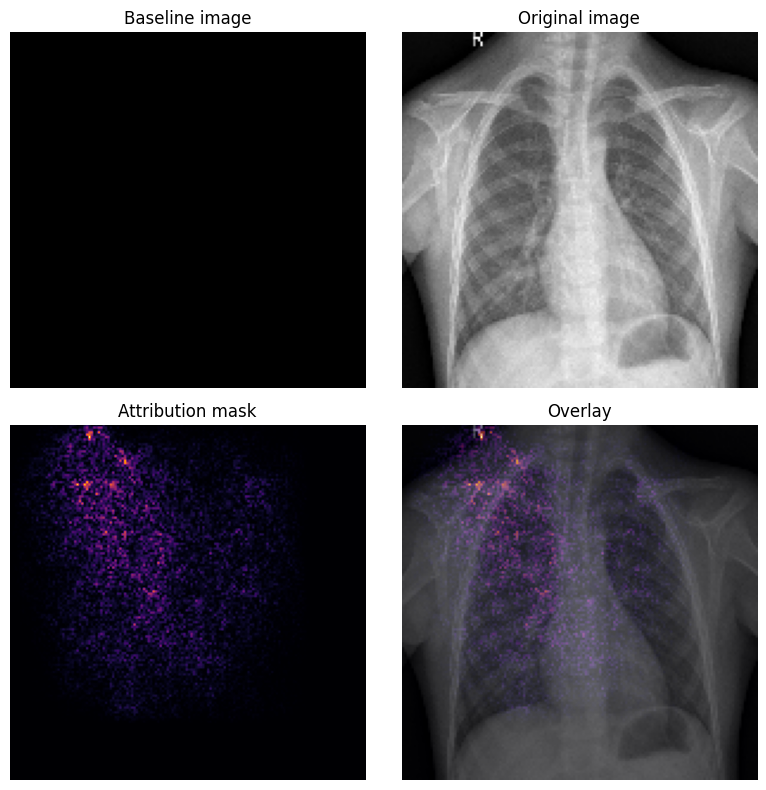

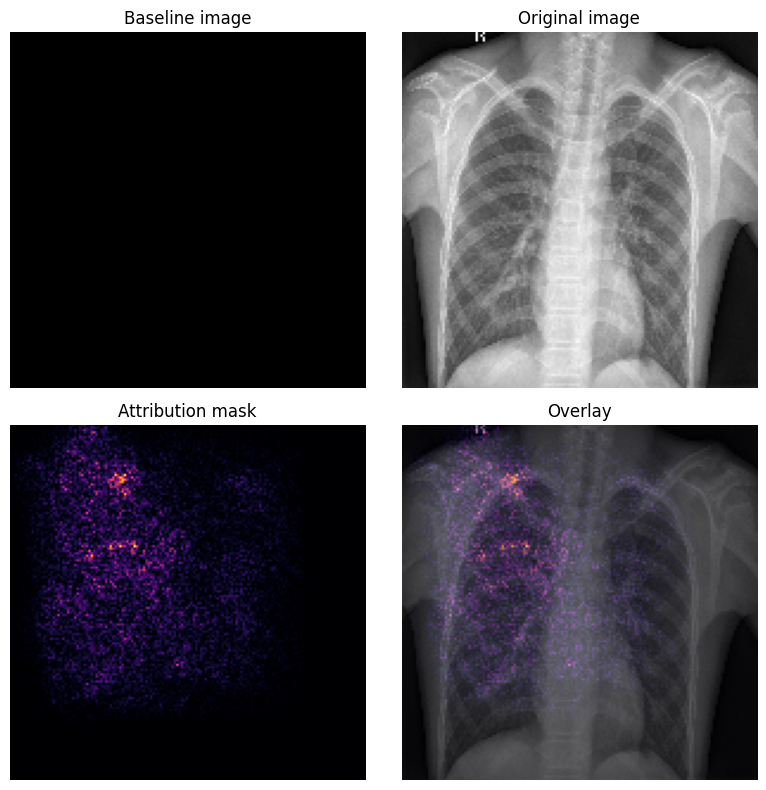

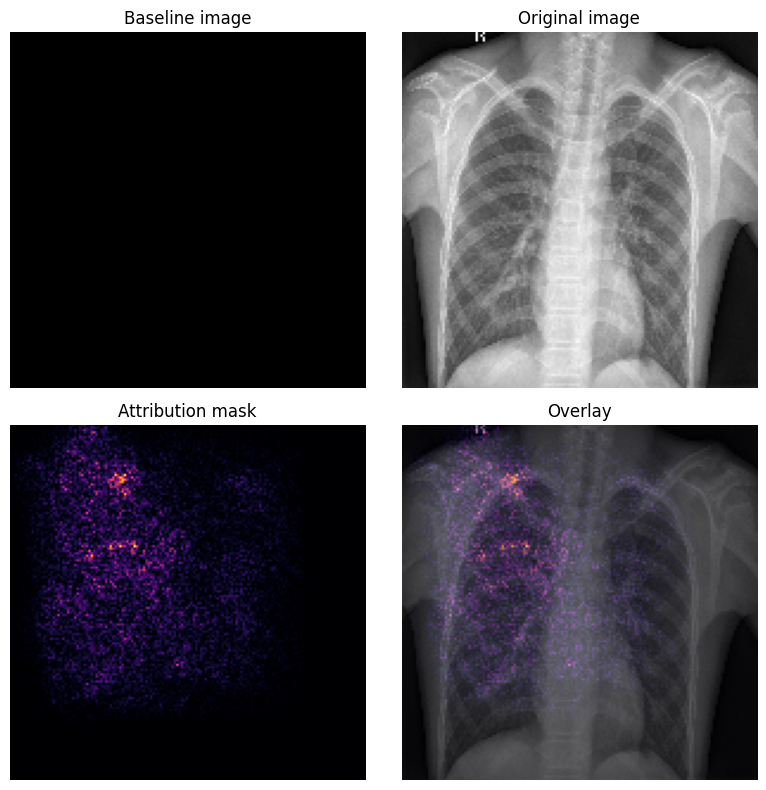

In [410]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          highlight_cmap=plt.cm.inferno,
                          background_cmap='gray',
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline, cmap=background_cmap)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image, cmap=background_cmap)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=highlight_cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=highlight_cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha, cmap=background_cmap)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig



g1 = tf.random.Generator.from_seed(1)
for _ in range(3):
  idx = tf_randint(0, Xs["test"].shape[0])
  plot_img_attributions(image=Xs["test"][idx],
                            baseline=baseline,
                            target_class_idx=ys["test"][idx],
                            m_steps=240)

Q4: Grad-CAM6 (5 Pts)
Grad-CAM is another post-hoc method that generates attribution maps. Like in Q3, implement
the method and visualize attribution maps of five healthy and five disease test samples. Do the maps highlight sensible regions? Are attributions consistent across samples? Compare your
findings with Q3.

In [420]:
#get title of last layer
cnn.summary()
#cnn.layers[-4]._name #access name of output layer

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 17, 17, 64)     

'max_pooling2d_56'

implement the method ö code still almost identical

In [423]:
#inspired by https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353
#params dependent on our model
last_conv2d_layer_idx = -4



def grad_cam6(img_array, target_layer_index = last_conv2d_layer_idx):
   #define layer we want the heatmap for
   target_layer = cnn.layers[target_layer_index]._name
   cnn_blackbox = keras.Model(inputs=[cnn.inputs],outputs=[cnn.get_layer(target_layer).output, cnn.output])

   with tf.GradientTape() as tape:
      # cast the image tensor to a float-32 data type, pass the
      # forward propagate the image through the gradient model, and grab the loss
      # associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = cnn_blackbox(inputs)
      loss = predictions[:, 0]
      #print(convOutputs)
      #print()
      #print(predictions)
   # use automatic differentiation to compute the gradients
   grads = tape.gradient(loss, convOutputs)
   #print(grads)
   # compute the guided gradients
   castConvOutputs = tf.cast(convOutputs > 0, "float32")
   castGrads = tf.cast(grads > 0, "float32")
   guidedGrads = castConvOutputs * castGrads * grads
   #print(guidedGrads)
   # the convolution and guided gradients have a batch dimension
   # (which we don't need) so let's grab the volume itself and
   # discard the batch
   convOutputs = convOutputs[0]
   guidedGrads = guidedGrads[0]
   # compute the average of the gradient values, and using them
   # as weights, compute the ponderation of the filters with
   # respect to the weights
   #print(guidedGrads.shape)
   #print(guidedGrads)
   weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
   cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
   # grab the spatial dimensions of the input image and resize
   # the output class activation map to match the input image
   # dimensions
   (w, h) = (img_array.shape[2], img_array.shape[1])
   #print(cam)
   #print(w, h)
   #print(cam.numpy().shape)
   heatmap = cv2.resize(cam.numpy(), (w, h))
   # normalize the heatmap such that all values lie in the range
   # [0, 1], scale the resulting values to the range [0, 255],
   # and then convert to an unsigned 8-bit integer
   eps = 1e-10 #still playing around with this value
   numer = heatmap - np.min(heatmap)
   denom = (heatmap.max() - heatmap.min()) + eps
   heatmap = numer / denom

   return heatmap
   


visualize attribution maps of five healthy and five disease test samples ö code still almost identical

In [424]:
#generate heatmaps 5 pseudorandom healthy and diseased samples
tf.random.set_seed(1234)
rand.seed(1234)

hs, ds = [], []
sample_cnt = 5

while len(hs)<sample_cnt or len(ds)<sample_cnt:
   idx = rand.randint(0, Xs["test"].shape[0])
   #print(idx)
   if ys["test"][idx] == 0:
      hs.append(grad_cam6(Xs["test"][idx]))
   else:
      ds.append(grad_cam6(Xs["test"][idx]))


def plot_heatmap_rows(heatmaps, columns=5):
    #plot images corresponding to list of file names in a horizontal row
    plt.figure(figsize=(20,10))
    
    for i, hm in enumerate(heatmaps):
        #create subplots to match grid
        plt.subplot(len(heatmaps) // columns + 1, columns, i + 1)
        plt.imshow(hm, cmap=plt.cm.inferno)
        plt.axis('off')
        #get title
        if i<sample_cnt:   title = "healthy"
        else:     title = "disease"
        plt.title(title)

plot_heatmap_rows(hs[:5]+ds[:5])



ValueError: Exception encountered when calling layer 'model_274' (type Functional).

Input 0 of layer "conv2d_75" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (150, 150)

Call arguments received by layer 'model_274' (type Functional):
  • inputs=tf.Tensor(shape=(150, 150), dtype=float32)
  • training=None
  • mask=None

Do the maps highlight sensible regions? ä
Yes usually the inner parts of the lung which we identified in Q1 as well.

Are attributions consistent across samples? ä
Yes usually the inner parts of the lung which we identified in Q1 as well.

Compare your findings with Q3. ä
This is better

Q5: Data Randomization Test7 (3 Pts)
Recently, the paper “Sanity Checks for Saliency Maps.” introduced the data randomization test
to check how trustworthiness of the saliency maps of specific methods. They propose to retrain
the classifier on the train set when randomly permuting labels of all samples. Then, they
compare the saliency maps on test samples for the perturbed and unperturbed classifiers. We
expect the map to change if an attribution map accurately captures the relationship between
instances and their labels. Conversely, if the attribution map captures another concept, e.g., acts
like an edge detector independent of the label, we expect the maps to stay the same. Retrain
your CNN on random training labels and perform the Data randomization Test for both
Integrated Gradients and Grad-CAM. Do they pass or fail? Elaborate and visualize your
findings!

Retrain your CNN on random training labels

In [416]:
train_data = gen.flow(Xs["train"].reshape(5216,150,150,1), ys["train"].reshape(-1,1),batch_size=20)
valid_data = gen.flow(Xs["val"].reshape(16,150,150,1), ys["val"].reshape(-1,1))
test_data = gen.flow(Xs["test"].reshape(624,150,150,1), ys["test"].reshape(-1,1))

perform the Data randomization Test for both Integrated Gradients and Grad-CAM

Do they pass or fail?

Elaborate and visualize your findings!

Challenge 2: Prototype Learning (10 Pts)
A radically different idea for interpretable classification is finding prototypical samples for each
class. Then, in addition to the prediction, we can return the prototype most similar to the input.
This idea was explored in the paper “Examples are not Enough, Learn to Criticize! Criticism for
Interpretability”8. They provide a method that allows you to extract representative prototypes
from a given dataset by using the maximum mean discrepancy (MMD) measure as a distance
function and introducing a kNN-like classifier. After reading the paper, we ask you to implement
their method in two steps:
1.
Implement the “Nearest Prototype Classifier” described in Section 5 of the paper. For
now, set the set of prototypes S to be random points of the training set. Report the
classification performance of this model on the test set.
2.
Implement the function Jb(S) (Section 3) and select prototypes S through their greedy
algorithm (Algorithm 1). Refit the classifier, this time with the selected prototypes, and
compare classification performance to random prototypes. Does the result behave as
you expected? Why or why not? Visualize five healthy and five disease prototypes. Do
you find representative class patterns among them? Would you say they look
prototypical?
How could you improve performance beyond simply applying kNN to the raw images? Compare
this type of interpretable method to the previously seen saliency maps. Which method do you
think is more useful? Can you think of scenarios where one is more valuable than the other?

Implement the “Nearest Prototype Classifier” described in Section 5 of the paper. For
now, set the set of prototypes S to be random points of the training set. 

Report the classification performance of this model on the test set.

Implement the function Jb(S) (Section 3) and select prototypes S through their greedy
algorithm (Algorithm 1).

Refit the classifier, this time with the selected prototypes, and
compare classification performance to random prototypes. 

Does the result behave as you expected? Why or why not?

Visualize five healthy and five disease prototypes. 

Do you find representative class patterns among them? Would you say they look
prototypical?

How could you improve performance beyond simply applying kNN to the raw images? Compare
this type of interpretable method to the previously seen saliency maps. Which method do you
think is more useful? Can you think of scenarios where one is more valuable than the other?